In [1]:
%matplotlib ipympl
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterable
from simulate_dicke import sim_dicke


In [2]:
def plot_sim_dicke(
    N: int,
    T: float,
    n: int = 0,
    freq: float = 1.0,
    coup: float = 1.0,
    time_step=None,
    spin_state_name="excited",
):
    """
    Only for quick simulations.
    """
    tt, vt, et, duration = sim_dicke(
        N=N,
        T=T,
        n=n,
        freq=freq,
        coup=coup,
        time_step=time_step,
        spin_state_name=spin_state_name,
    )
    plt.scatter(tt, np.real_if_close(et[0]), s=10)
    plt.xlabel("t")
    plt.ylabel("$\\langle v(t), \\hat n v(t)\\rangle$")
    plt.title(f"N={N}")
    plt.show()

In [3]:
# with open("dicke_sim_09_01_2025-16_19_05_N-2-20_T-6.0.pickle", "rb") as file:
#     data = pickle.load(file)

with open(
    "dicke_sim_09_01_2025-17_04_45_excited_N-2-60_T-6.0.pickle", "rb"
) as file:
    data_excited = pickle.load(file)

with open(
    "dicke_sim_10_01_2025-14_46_06_superradiant_N-2-60_T-6.0.pickle", "rb"
) as file:
    data_superradient = pickle.load(file)

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

In [31]:
def plot_data(
    data: list[dict],
    max_N: int = None,
    min_N: int = None,
    N_selection: Iterable = None,
    y: tuple = (None, None),
    x: tuple = (None, None),
):
    ys = np.array([np.real_if_close(res["et"][0]) for res in data])[::-1]
    xs = np.array([res["tt"] for res in data])[::-1]
    Ns = np.array([res["N"] for res in data])[::-1]

    min_x, max_x = x
    min_y, max_y = y

    if max_N is None:
        max_N = max(Ns)
    if min_N is None:
        min_N = min(Ns)

    # apriori filter for everything
    filter = np.logical_and(Ns <= max_N, min_N <= Ns)

    xs = xs[filter]
    ys = ys[filter]
    Ns = Ns[filter]

    fig, ax = plt.subplots()
    fig.set_layout_engine("constrained")
    w, h = fig.get_size_inches()
    aspectratio = h / w
    width = 8
    fig.set_size_inches(width, width * aspectratio, forward=False)

    # ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

    cmap = truncate_colormap(mpl.cm.viridis, 0.2, 0.92, len(ys))
    colors = cmap(np.linspace(0, 1, len(ys)))

    # a posterori filter just for the selection of graphs, colors are unaffected
    if N_selection is not None:
        selection_filter = np.isin(Ns, N_selection)
    if N_selection is None:
        selection_filter = np.ones_like(Ns)

    for N, x, y, c, f in zip(Ns, xs, ys, colors, selection_filter):
        if f:
            ax.plot(
                x,
                y,
                "o-",
                alpha=0.7,
                # linewidth=1.5,
                # markeredgewidth=1,
                markersize=2.5,
                label=f"N={N}",
                color=c,
            )

    ax.set_xlabel("t")
    ax.set_ylabel("$\\langle v(t), \\hat n v(t)\\rangle$")

    if max_y is not None and min_y is not None:
        ax.set_ylim(min_y, max_y)
    if max_x is not None and min_x is not None:
        ax.set_xlim(min_x, max_x)

    bounds = Ns
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        label="N",
        ax=ax,
        orientation="vertical",
        # ticks=Ns,
    )

    # always add highest N to ticks
    cbar_ticks = list(cbar.get_ticks())
    cbar_ticks.append(Ns[-1])
    if cbar_ticks[-1] - cbar_ticks[-2] <= 1:
        cbar_ticks.pop(-2)

    # filter ticks for selected graphs
    if N_selection is not None:
        cbar_ticks = N_selection

    cbar_ticks = np.array(cbar_ticks)

    cbar.set_ticks(cbar_ticks)
    return fig


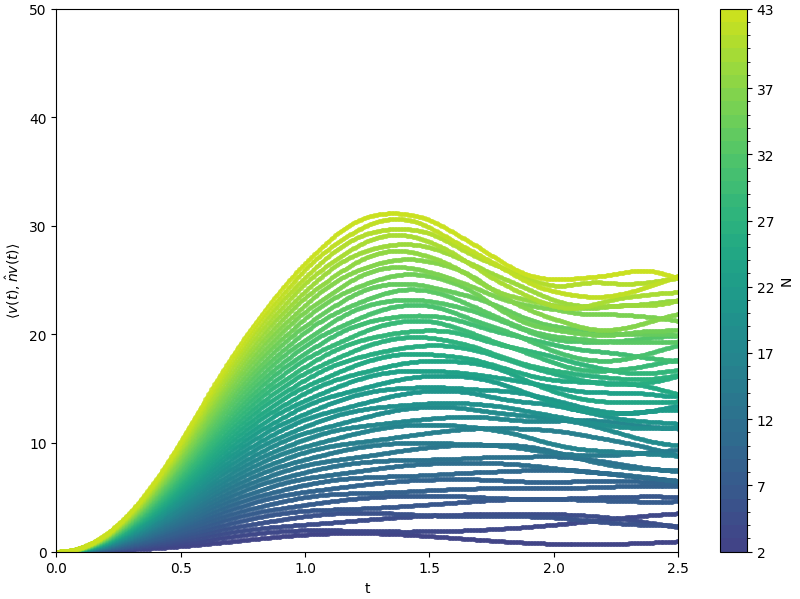

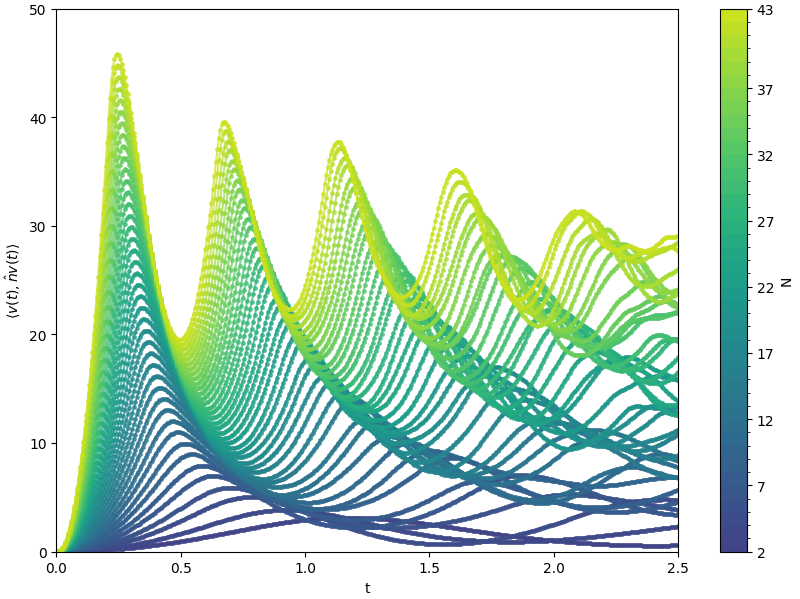

In [33]:
fig1 = plot_data(data_excited, max_N=43, x=(0, 2.5), y=(0, 50))
fig1s = plot_data(data_superradient, max_N=43, x=(0, 2.5), y=(0, 50))
# fig2 = plot_data(data_excited, max_N=43, x=(0, 3))
# fig3 = plot_data(data_excited, max_N=43, x=(0, 2))
# fig4 = plot_data(data_excited, max_N=43, N_selection=[22, 30, 7])

- consider steepness of initial slope
- consider highpoint of initial slope
- consider average after initial slope


Above N=43 there are numerical artifacts. Possibly need to increase time_step


In [7]:
# write function for approximating the slope locally


def slope(x1, y1, x2, y2) -> float:
    return (y2 - y1) / (x2 - x1)


def arr_slope(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    y1 = y[:-1]
    x1 = x[:-1]
    y2 = y[1:]
    x2 = x[1:]

    return slope(x1, y1, x2, y2)


# select time interval of first slope

# approximate steepness by linear fit

# get maximal value of first slope

# select time interval of first bump

(0.0, 50.0)

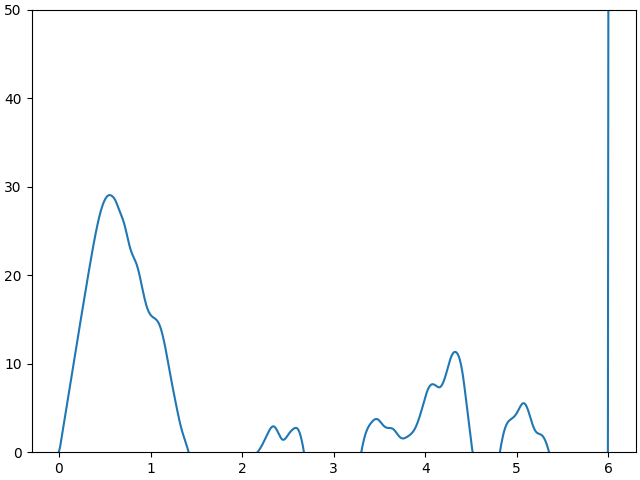

In [34]:
ys = np.array([np.real_if_close(res["et"][0]) for res in data_excited])[::-1]
xs = np.array([res["tt"] for res in data_excited])[::-1]

dy = arr_slope(xs[-1], ys[-1])
fig, ax = plt.subplots(layout="constrained")
i = 30
ax.plot(xs[i][:-1], arr_slope(xs[i], ys[i]))
ax.set_ylim(0, 50)
